In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
print(tf.__version__)
print(matplotlib.__version__)
print(np.__version__)

2.1.0
3.0.3
1.18.2


In [2]:
#hyperparameters
latent_dim = 100
lr = 1e-3
epochs = 1000
save_interval = 50
batch_size = 256
dropout_rate = 0.2
seed = 500

In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.Dense_1 = tf.keras.layers.Dense(128)
        self.Dense_2 = tf.keras.layers.Dense(28*28, activation='sigmoid')
        
        self.reshape = tf.keras.layers.Reshape((28,28,1))
    
    def call(self, inputs):
        x = self.Dense_1(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.Dense_2(x)
        x = self.reshape(x)
        return x

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        
        self.Dense_1 = tf.keras.layers.Dense(128)

        self.Dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.Dense_1(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.dropout_1(x)
        x = self.Dense_2(x)
        return x

In [6]:
gen = Generator()
disc = Discriminator()

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.cast(x_train, tf.float32)/255.
x_train = x_train[..., tf.newaxis]

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [9]:
gen_opt = tf.keras.optimizers.Adam(lr)
disc_opt = tf.keras.optimizers.Adam(lr)

In [10]:
@tf.function
def train_step(images, batch_size):
    #train the discriminator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        real_prob = disc(images)
        generated_prob = tf.debugging.check_numerics(disc(gen_images), 'disc prob of generated images')        

        disc_loss = -tf.reduce_mean(tf.math.log(real_prob) + tf.math.log(1. - generated_prob))
         
    tf.debugging.check_numerics(tf.math.log(real_prob), 'disc loss real prob part')
    tf.debugging.check_numerics(tf.math.log(1. - generated_prob), 
                                'disc loss gen prob part {}'.format(tf.math.reduce_max(generated_prob)))
        
    grad_disc = tape.gradient(disc_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(grad_disc, disc.trainable_variables))
    
    #train the generator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        generated_prob = disc(gen_images)
                
        gen_loss = -tf.reduce_mean(tf.math.log(generated_prob))
        
    tf.debugging.check_numerics(tf.math.log(generated_prob), 'gen loss part')
    
    grad_gen = tape.gradient(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    
    disc_real_acc = tf.reduce_mean(1 - (tf.ones_like(real_prob) - tf.cast(real_prob>=0.5, tf.float32)))
    disc_gen_acc = tf.reduce_mean(1 - (tf.ones_like(generated_prob) - tf.cast(generated_prob>=0.5, tf.float32)))
    
    return gen_loss, disc_loss, disc_real_acc, disc_gen_acc


In [11]:
def save_imgs(epoch, generator, noise):    
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs.numpy()
    fig = plt.figure(figsize=(5, 5))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')
    fig.savefig("images/mnist_%d.png" % epoch)

In [12]:
vis_noise = tf.random.normal([16, latent_dim])

Time for epoch 1 is 2.788 sec - gen_loss = 5.384, disc_loss = 0.199, disc_real_acc = 0.95, disc_gen_acc = 0.0
Time for epoch 2 is 1.136 sec - gen_loss = 10.426, disc_loss = 0.066, disc_real_acc = 0.99, disc_gen_acc = 0.0
Time for epoch 3 is 1.082 sec - gen_loss = 8.025, disc_loss = 0.03, disc_real_acc = 1.0, disc_gen_acc = 0.0
Time for epoch 4 is 1.077 sec - gen_loss = 6.411, disc_loss = 0.04, disc_real_acc = 1.0, disc_gen_acc = 0.0
Time for epoch 5 is 1.118 sec - gen_loss = 6.797, disc_loss = 0.044, disc_real_acc = 0.99, disc_gen_acc = 0.0
Time for epoch 6 is 1.104 sec - gen_loss = 5.982, disc_loss = 0.082, disc_real_acc = 0.99, disc_gen_acc = 0.01
Time for epoch 7 is 1.099 sec - gen_loss = 6.157, disc_loss = 0.114, disc_real_acc = 0.98, disc_gen_acc = 0.01
Time for epoch 8 is 1.125 sec - gen_loss = 5.228, disc_loss = 0.144, disc_real_acc = 0.98, disc_gen_acc = 0.01
Time for epoch 9 is 1.146 sec - gen_loss = 5.351, disc_loss = 0.187, disc_real_acc = 0.97, disc_gen_acc = 0.01
Time for 

Time for epoch 75 is 1.368 sec - gen_loss = 2.618, disc_loss = 0.812, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 76 is 1.361 sec - gen_loss = 2.814, disc_loss = 0.737, disc_real_acc = 0.83, disc_gen_acc = 0.12
Time for epoch 77 is 1.339 sec - gen_loss = 2.759, disc_loss = 0.701, disc_real_acc = 0.84, disc_gen_acc = 0.12
Time for epoch 78 is 1.343 sec - gen_loss = 2.601, disc_loss = 0.702, disc_real_acc = 0.83, disc_gen_acc = 0.12
Time for epoch 79 is 1.275 sec - gen_loss = 2.391, disc_loss = 0.744, disc_real_acc = 0.82, disc_gen_acc = 0.13
Time for epoch 80 is 1.104 sec - gen_loss = 2.316, disc_loss = 0.765, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 81 is 1.133 sec - gen_loss = 2.349, disc_loss = 0.773, disc_real_acc = 0.82, disc_gen_acc = 0.13
Time for epoch 82 is 1.164 sec - gen_loss = 2.654, disc_loss = 0.835, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 83 is 1.287 sec - gen_loss = 2.931, disc_loss = 0.734, disc_real_acc = 0.83, disc_gen_acc

Time for epoch 149 is 1.114 sec - gen_loss = 1.858, disc_loss = 0.848, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 150 is 1.262 sec - gen_loss = 1.903, disc_loss = 0.851, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 151 is 1.408 sec - gen_loss = 2.03, disc_loss = 0.869, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 152 is 1.417 sec - gen_loss = 2.199, disc_loss = 0.849, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 153 is 1.191 sec - gen_loss = 2.252, disc_loss = 0.825, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 154 is 1.118 sec - gen_loss = 2.206, disc_loss = 0.796, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 155 is 1.22 sec - gen_loss = 2.101, disc_loss = 0.824, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 156 is 1.299 sec - gen_loss = 1.981, disc_loss = 0.828, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 157 is 1.376 sec - gen_loss = 1.944, disc_loss = 0.838, disc_real_acc = 0.79, disc_gen

Time for epoch 222 is 1.444 sec - gen_loss = 1.948, disc_loss = 0.855, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 223 is 1.271 sec - gen_loss = 2.002, disc_loss = 0.844, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 224 is 1.3 sec - gen_loss = 2.041, disc_loss = 0.824, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 225 is 1.119 sec - gen_loss = 1.997, disc_loss = 0.828, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 226 is 1.252 sec - gen_loss = 1.961, disc_loss = 0.838, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 227 is 1.398 sec - gen_loss = 1.946, disc_loss = 0.839, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 228 is 1.479 sec - gen_loss = 1.903, disc_loss = 0.835, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 229 is 1.595 sec - gen_loss = 1.866, disc_loss = 0.866, disc_real_acc = 0.78, disc_gen_acc = 0.16
Time for epoch 230 is 1.614 sec - gen_loss = 1.918, disc_loss = 0.838, disc_real_acc = 0.79, disc_

Time for epoch 295 is 1.488 sec - gen_loss = 1.864, disc_loss = 0.84, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 296 is 1.403 sec - gen_loss = 1.888, disc_loss = 0.848, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 297 is 1.441 sec - gen_loss = 1.908, disc_loss = 0.841, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 298 is 1.408 sec - gen_loss = 1.919, disc_loss = 0.84, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 299 is 1.367 sec - gen_loss = 1.964, disc_loss = 0.835, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 300 is 1.411 sec - gen_loss = 1.951, disc_loss = 0.842, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 301 is 1.443 sec - gen_loss = 1.972, disc_loss = 0.834, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 302 is 1.405 sec - gen_loss = 1.947, disc_loss = 0.832, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 303 is 1.37 sec - gen_loss = 1.95, disc_loss = 0.828, disc_real_acc = 0.79, disc_ge

Time for epoch 368 is 1.389 sec - gen_loss = 2.03, disc_loss = 0.806, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 369 is 1.328 sec - gen_loss = 1.962, disc_loss = 0.8, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 370 is 1.351 sec - gen_loss = 1.967, disc_loss = 0.812, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 371 is 1.244 sec - gen_loss = 1.966, disc_loss = 0.805, disc_real_acc = 0.79, disc_gen_acc = 0.14
Time for epoch 372 is 1.124 sec - gen_loss = 1.931, disc_loss = 0.804, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 373 is 1.116 sec - gen_loss = 1.895, disc_loss = 0.816, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 374 is 1.121 sec - gen_loss = 1.927, disc_loss = 0.811, disc_real_acc = 0.79, disc_gen_acc = 0.14
Time for epoch 375 is 1.321 sec - gen_loss = 1.932, disc_loss = 0.811, disc_real_acc = 0.79, disc_gen_acc = 0.14
Time for epoch 376 is 1.339 sec - gen_loss = 1.93, disc_loss = 0.813, disc_real_acc = 0.79, disc_gen_

Time for epoch 442 is 2.377 sec - gen_loss = 2.039, disc_loss = 0.761, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 443 is 1.924 sec - gen_loss = 1.975, disc_loss = 0.782, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 444 is 1.895 sec - gen_loss = 1.98, disc_loss = 0.766, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 445 is 1.532 sec - gen_loss = 1.977, disc_loss = 0.768, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 446 is 1.471 sec - gen_loss = 1.975, disc_loss = 0.771, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 447 is 1.492 sec - gen_loss = 1.992, disc_loss = 0.774, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 448 is 1.672 sec - gen_loss = 1.985, disc_loss = 0.771, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 449 is 1.671 sec - gen_loss = 2.005, disc_loss = 0.771, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 450 is 1.596 sec - gen_loss = 2.055, disc_loss = 0.762, disc_real_acc = 0.8, disc_gen_acc 

Time for epoch 516 is 1.211 sec - gen_loss = 2.097, disc_loss = 0.726, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 517 is 1.376 sec - gen_loss = 2.098, disc_loss = 0.732, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 518 is 1.361 sec - gen_loss = 2.129, disc_loss = 0.729, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 519 is 1.396 sec - gen_loss = 2.128, disc_loss = 0.728, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 520 is 1.526 sec - gen_loss = 2.118, disc_loss = 0.724, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 521 is 1.534 sec - gen_loss = 2.105, disc_loss = 0.748, disc_real_acc = 0.8, disc_gen_acc = 0.12
Time for epoch 522 is 2.01 sec - gen_loss = 2.1, disc_loss = 0.73, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 523 is 2.273 sec - gen_loss = 2.071, disc_loss = 0.733, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 524 is 1.795 sec - gen_loss = 2.051, disc_loss = 0.731, disc_real_acc = 0.81, disc_gen

Time for epoch 589 is 1.569 sec - gen_loss = 2.222, disc_loss = 0.694, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 590 is 1.552 sec - gen_loss = 2.211, disc_loss = 0.691, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 591 is 1.724 sec - gen_loss = 2.225, disc_loss = 0.698, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 592 is 1.432 sec - gen_loss = 2.237, disc_loss = 0.695, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 593 is 1.394 sec - gen_loss = 2.212, disc_loss = 0.699, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 594 is 1.423 sec - gen_loss = 2.211, disc_loss = 0.69, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 595 is 1.408 sec - gen_loss = 2.198, disc_loss = 0.697, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 596 is 1.332 sec - gen_loss = 2.151, disc_loss = 0.698, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 597 is 1.386 sec - gen_loss = 2.177, disc_loss = 0.699, disc_real_acc = 0.81, disc

Time for epoch 662 is 2.665 sec - gen_loss = 2.232, disc_loss = 0.676, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 663 is 2.234 sec - gen_loss = 2.223, disc_loss = 0.684, disc_real_acc = 0.81, disc_gen_acc = 0.11
Time for epoch 664 is 1.91 sec - gen_loss = 2.233, disc_loss = 0.682, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 665 is 1.778 sec - gen_loss = 2.215, disc_loss = 0.688, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 666 is 1.649 sec - gen_loss = 2.205, disc_loss = 0.674, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 667 is 1.637 sec - gen_loss = 2.187, disc_loss = 0.679, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 668 is 1.374 sec - gen_loss = 2.186, disc_loss = 0.683, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 669 is 1.356 sec - gen_loss = 2.221, disc_loss = 0.677, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 670 is 1.392 sec - gen_loss = 2.245, disc_loss = 0.675, disc_real_acc = 0.82, disc

Time for epoch 735 is 1.32 sec - gen_loss = 2.301, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 736 is 1.442 sec - gen_loss = 2.291, disc_loss = 0.662, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 737 is 1.448 sec - gen_loss = 2.267, disc_loss = 0.657, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 738 is 1.738 sec - gen_loss = 2.233, disc_loss = 0.665, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 739 is 2.197 sec - gen_loss = 2.253, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 740 is 1.927 sec - gen_loss = 2.252, disc_loss = 0.666, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 741 is 1.68 sec - gen_loss = 2.249, disc_loss = 0.662, disc_real_acc = 0.82, disc_gen_acc = 0.11
Time for epoch 742 is 1.644 sec - gen_loss = 2.231, disc_loss = 0.669, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 743 is 1.474 sec - gen_loss = 2.247, disc_loss = 0.659, disc_real_acc = 0.82, disc_gen_acc

Time for epoch 809 is 1.536 sec - gen_loss = 2.331, disc_loss = 0.653, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 810 is 1.68 sec - gen_loss = 2.376, disc_loss = 0.644, disc_real_acc = 0.83, disc_gen_acc = 0.1
Time for epoch 811 is 1.655 sec - gen_loss = 2.341, disc_loss = 0.656, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 812 is 2.138 sec - gen_loss = 2.318, disc_loss = 0.651, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 813 is 2.487 sec - gen_loss = 2.297, disc_loss = 0.648, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 814 is 1.897 sec - gen_loss = 2.31, disc_loss = 0.65, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 815 is 1.916 sec - gen_loss = 2.281, disc_loss = 0.656, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 816 is 1.671 sec - gen_loss = 2.303, disc_loss = 0.65, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 817 is 1.64 sec - gen_loss = 2.259, disc_loss = 0.661, disc_real_acc = 0.82, disc_gen_acc = 0

Time for epoch 883 is 1.52 sec - gen_loss = 2.29, disc_loss = 0.646, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 884 is 1.526 sec - gen_loss = 2.32, disc_loss = 0.644, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 885 is 1.581 sec - gen_loss = 2.31, disc_loss = 0.643, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 886 is 1.674 sec - gen_loss = 2.341, disc_loss = 0.644, disc_real_acc = 0.83, disc_gen_acc = 0.1
Time for epoch 887 is 1.811 sec - gen_loss = 2.312, disc_loss = 0.648, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 888 is 2.425 sec - gen_loss = 2.318, disc_loss = 0.641, disc_real_acc = 0.83, disc_gen_acc = 0.09
Time for epoch 889 is 2.126 sec - gen_loss = 2.311, disc_loss = 0.647, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 890 is 1.896 sec - gen_loss = 2.333, disc_loss = 0.639, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 891 is 2.137 sec - gen_loss = 2.333, disc_loss = 0.645, disc_real_acc = 0.82, disc_gen_acc =

Time for epoch 957 is 1.917 sec - gen_loss = 2.335, disc_loss = 0.648, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 958 is 1.659 sec - gen_loss = 2.323, disc_loss = 0.635, disc_real_acc = 0.83, disc_gen_acc = 0.1
Time for epoch 959 is 1.647 sec - gen_loss = 2.341, disc_loss = 0.638, disc_real_acc = 0.83, disc_gen_acc = 0.09
Time for epoch 960 is 1.782 sec - gen_loss = 2.321, disc_loss = 0.636, disc_real_acc = 0.82, disc_gen_acc = 0.09
Time for epoch 961 is 1.894 sec - gen_loss = 2.316, disc_loss = 0.638, disc_real_acc = 0.82, disc_gen_acc = 0.09
Time for epoch 962 is 1.788 sec - gen_loss = 2.336, disc_loss = 0.646, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 963 is 1.647 sec - gen_loss = 2.327, disc_loss = 0.636, disc_real_acc = 0.82, disc_gen_acc = 0.09
Time for epoch 964 is 1.651 sec - gen_loss = 2.301, disc_loss = 0.641, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 965 is 1.883 sec - gen_loss = 2.277, disc_loss = 0.638, disc_real_acc = 0.82, disc_ge

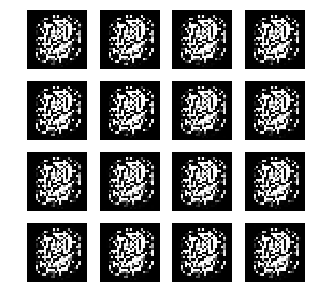

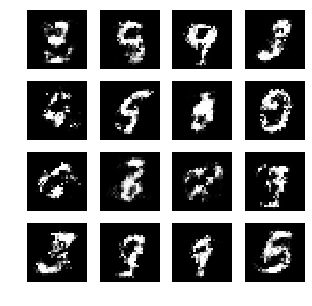

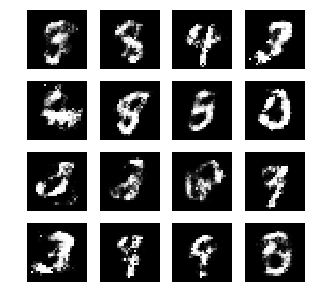

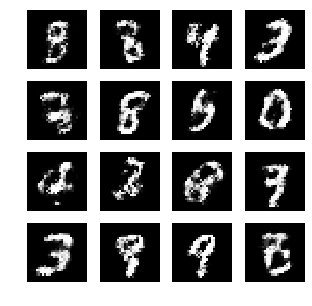

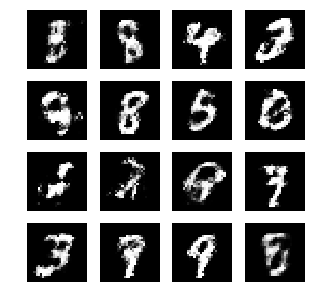

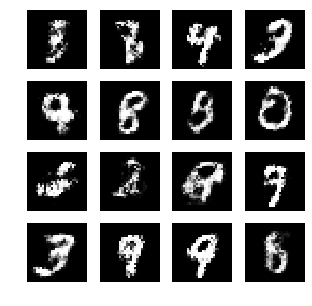

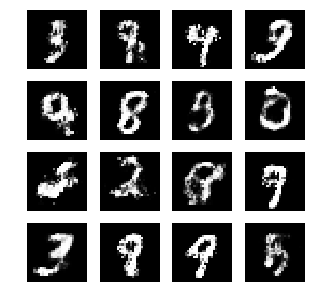

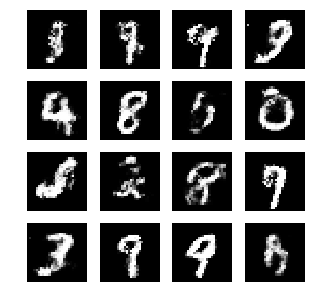

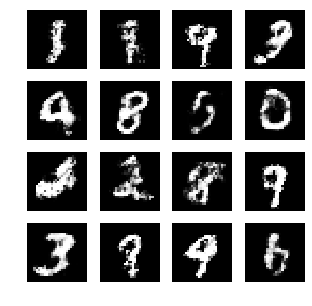

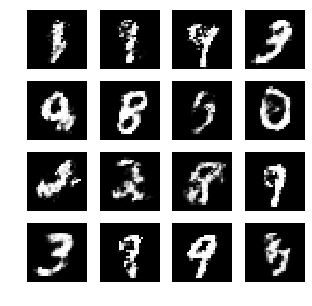

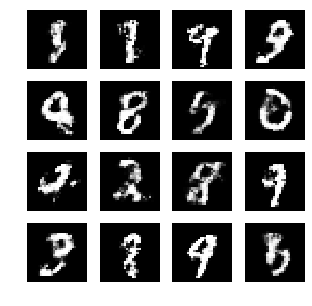

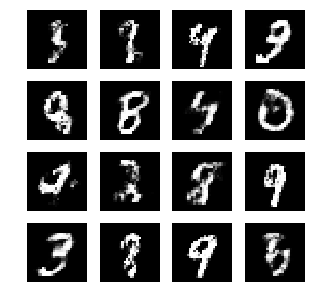

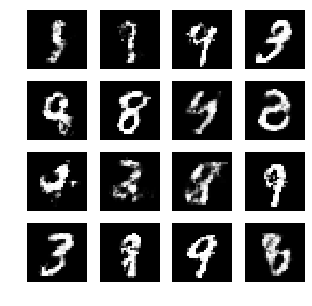

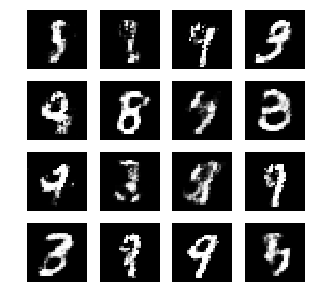

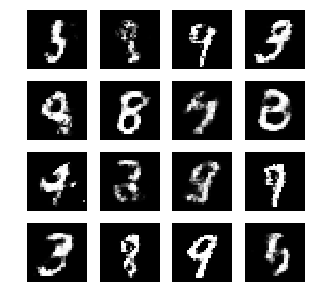

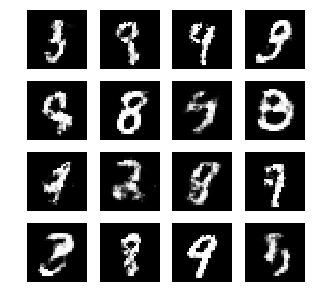

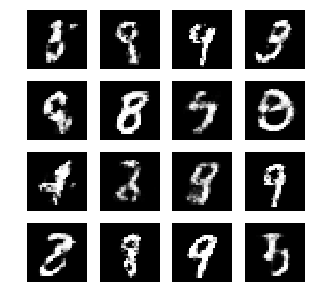

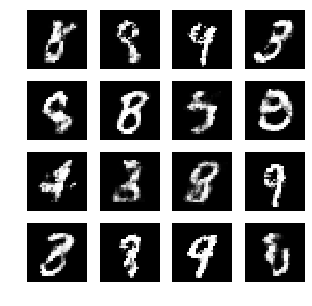

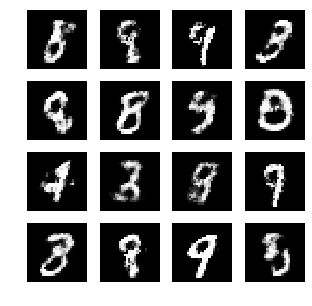

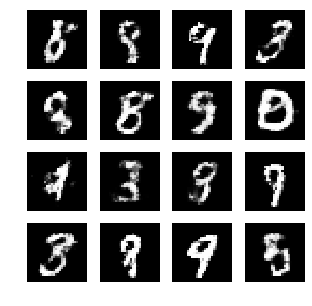

In [13]:
gen_loss_list = []
disc_loss_list = []
training_start_time = time.time()
for epoch in range(epochs):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    total_disc_real_acc = 0
    total_disc_gen_acc = 0
    count = 0

    for images,labels in train_ds:
#         print(images.shape)
        batch_s = images.shape[0]
        gen_loss, disc_loss, disc_real_acc, disc_gen_acc = train_step(images, batch_s)

        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        total_disc_real_acc += disc_real_acc
        total_disc_gen_acc += disc_gen_acc
        count += 1
    gen_loss_list.append(total_gen_loss.numpy()/count)
    disc_loss_list.append(total_disc_loss.numpy()/count)
    print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}, disc_real_acc = {}, disc_gen_acc = {}'.format(epoch + 1, 
                                                                                                   round(time.time() - start, 3), 
                                                                                                   round(total_gen_loss.numpy() / count, 3), 
                                                                                                   round(total_disc_loss.numpy() / count, 3), 
                                                                                                   round(total_disc_real_acc.numpy()/count, 2), 
                                                                                                   round(total_disc_gen_acc.numpy()/count, 2)))
    if epoch % save_interval == 0:
        save_imgs(epoch, gen, vis_noise)
training_time_in_hrs = (time.time() - training_start_time) / (60*60)
print('Total training time: {} hrs'.format(training_time_in_hrs))

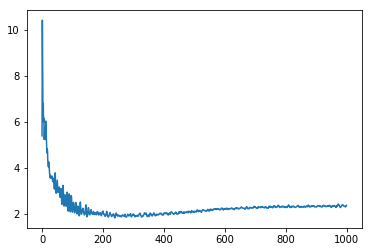

In [14]:
plt.plot(gen_loss_list)
plt.show()

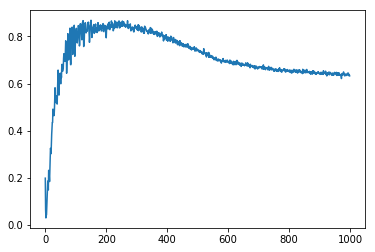

In [15]:
plt.plot(disc_loss_list)
plt.show()